In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-06-28 21:59:01.110866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 21:59:01.110900: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'Patch-Seq'
modality_names = ['Gene Expression', 'EPhys']
human_cells = pd.read_csv("../data/patchseq_human_L23/human_IVSCC_excitatory_L23_consolidated_0131.csv", index_col=0)
human_morph = pd.read_csv("../data/patchseq_human_L23/All_L23_Lockdown_all_raw_features.csv", index_col=0)
ephys = pd.read_csv("../data/patchseq_human_L23/human_mouse_ephys_all_0127.csv", index_col=0)
sample_names = list(set(human_cells.index) & set(human_morph.index) & set(ephys.index))
data1 = human_morph.loc[sample_names]
data2 = ephys.loc[sample_names]
type1 = type2 = np.array(human_cells.loc[sample_names]['contaminationType'])  # medical_conditions, contaminationType

# Labels
labels = [type1, type2]
features = [None, None]

# Preprocessing
data1 = np.nan_to_num(preprocessing.scale(data1, axis=0))
data2 = np.nan_to_num(preprocessing.scale(data2, axis=0))
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [5]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 50
pca_dim = None

# ComManDo

In [6]:
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': 'euclidean',
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.4074 alpha:0.5585
epoch:[1000/2000] err:0.3769 alpha:0.5754
epoch:[1500/2000] err:0.3589 alpha:0.5865
epoch:[2000/2000] err:0.3369 alpha:0.5959
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.069677
epoch:[1000/2000]: loss:0.832541
epoch:[1500/2000]: loss:0.804999
epoch:[2000/2000]: loss:0.801830
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.023680680000325083
Correspondence: 0.6656740870002977
Mapping: 18.70026453600076
Total: 19.389619303001382

use random seed: 666
Shape of Raw data
Dataset 0: (103, 60)
Dataset 1: (103, 18)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.094574
epoch:[1000/2000]: loss:0.862901
epoch:[1500/2000]: loss:0.781221
epoch:[2000/2000

In [7]:
# Imputation
cm_imputed = [cm.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

# Comparison Methods

In [8]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

In [9]:
# NN
nn_imputed = [predict_nn(torch.tensor(dataset[i]).float(), torch.tensor(dataset[(i+1)%2]).float()) for i in range(1, -1, -1)]

# Visualization

In [10]:
integrated_data = [cm_data, nlma_data, lma_data, cca_data]
integrated_names = ['JAMIE', 'Nonlinear Manifold\nAlignment', 'Linear Manifold\nAlignment', 'CCA']
imputed_data = [cm_imputed, nn_imputed]
imputed_names = ['JAMIE', 'NN']
colors = ['blue', 'red', 'green', 'm']

sns.set(style='whitegrid')
plt.rcParams.update({'font.weight': 'normal'})

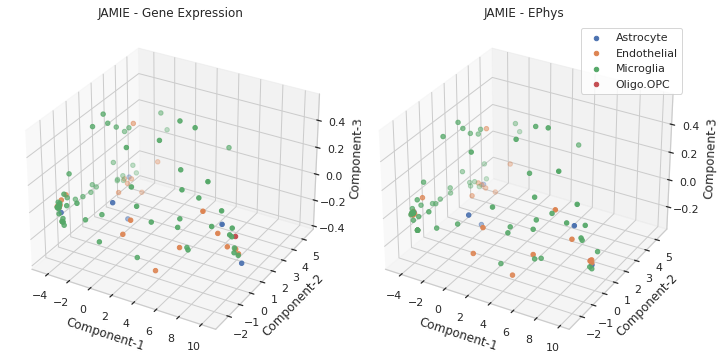

In [11]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

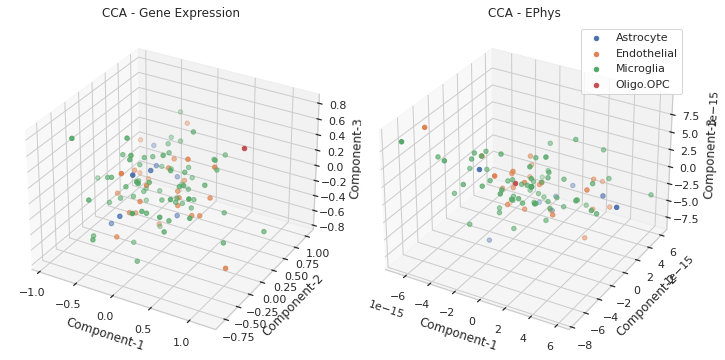

In [12]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cca_data, labels, ['CCA - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-CCA.png')

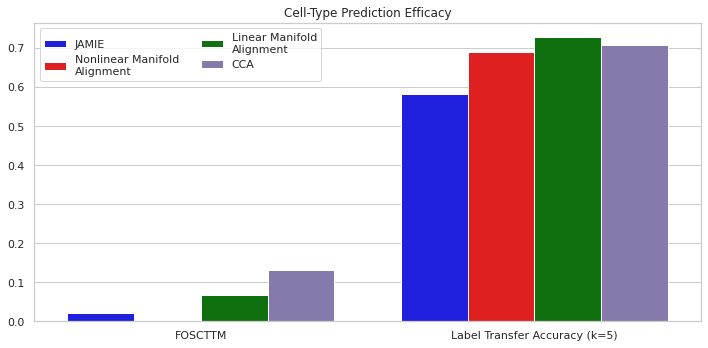

In [13]:
plt.figure(figsize=(10, 5))
plot_accuracy(integrated_data, labels, integrated_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

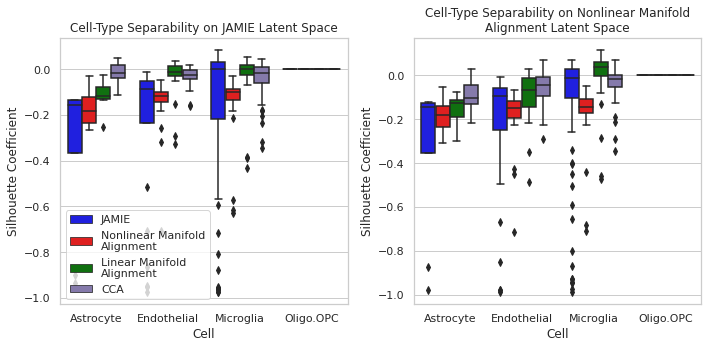

In [14]:
plt.figure(figsize=(10, 5))
plot_silhouette(integrated_data, labels, integrated_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

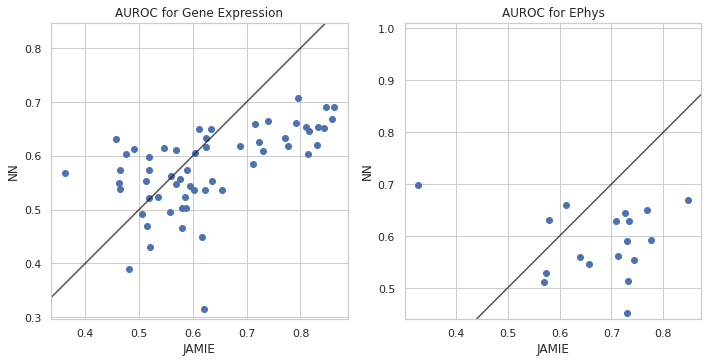

In [15]:
plt.figure(figsize=(10, 5))
plot_auroc(imputed_data, dataset, modality_names, imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Impute.png')

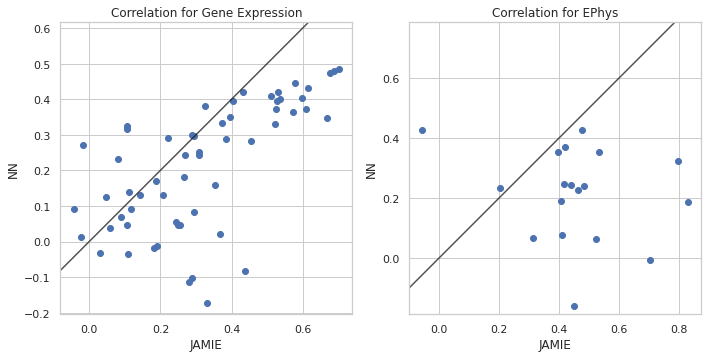

In [16]:
plt.figure(figsize=(10, 5))
plot_correlation(imputed_data, dataset, modality_names, imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Corr.png')